In [1]:
import os
import datetime
import numpy as np
#import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import uproot
import math
from glob import glob
import awkward as ak
%matplotlib inline

%load_ext autoreload
%autoreload 2

prop_cycle = plt.rcParams['axes.prop_cycle']
_colors = prop_cycle.by_key()['color']

_save_dir = 'plots/'

# colors = {
#     211: 'lightgreen',
#     2122: 'lightblue',
#     13: 'blue',
#     11: 'navy',
#     111: 'black'
# }

colors = ['black', 'navy', 'blue', 'lightblue', 'lightgreen',]

# lariat colors
colors = [
    # 'gray', 
    (24/ 255, 33/ 255, 92/ 255),
    (109/ 255, 102/ 255, 146/ 255),
    (88/ 255, 130/ 255, 175/ 255),
    (129/ 255, 181/ 255, 203/ 255),
    (197/ 255, 221/ 255, 205/ 255),
]

In [12]:
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/18jun2024/merged_1692of35k_19jun2024_reprocessed.root'
# n_pions = 1692*35000

# From Supraja, 22 aug 2022, config 1
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/22jun2024/merged_4184of35k_22jun2024_skimmed.root'
# f = '/exp/lariat/data/users/mdeltutt/merged_4184of35k_22jun2024_skimmed.root'
# n_pions = 4184*35000
f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/22jun2024/merged_0000of35k_22jun2024_skimmed.root'
n_pions = 9645*35000
config = 'config1'

# From Supraja, 2 sept 2022, config 2
# f = '/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/arcs_beamline_2sep2022_22jun2024/merged_9036of30k_config2_skimmed.root'
# n_pions = 9036 * 30000
# config = 'config2'


In [13]:
file = uproot.open(f)
file.keys()

n_spills = n_pions / 2.5e5
n_hours = n_spills / 60
n_months = n_spills / 60 / 24 / 30

print('Number of pions:', n_pions)
print('Number of spills:', n_spills)
print('Number of hours:', n_hours)
print('Number of months:', n_months)


Number of pions: 337575000
Number of spills: 1350.3
Number of hours: 22.505
Number of months: 0.03125694444444444


In [14]:
f'Particles / {n_pions:.1e} $\pi$ on target ({n_hours} hours of data)' 

'Particles / 3.4e+08 $\\pi$ on target (22.505 hours of data)'

In [15]:
det = 4
branches = [f'PxDet{det}', f'PyDet{det}', f'PzDet{det}', f'PDGidDet{det}', f'TrackPresentDet{det}']
arrays = file[f'EventsDet{det}'].arrays(branches, entry_start=0, entry_stop=1)

In [16]:
file[f'EventsDet4'].num_entries
file.keys()

['EventsDet1;2',
 'EventsDet2;2',
 'EventsDet3;2',
 'EventsDet4;2',
 'EventsDet5;2',
 'EventsDet6;2',
 'EventsDet7;2',
 'EventsTOFus;2',
 'EventsTOFus;1',
 'EventsTOFds;2']

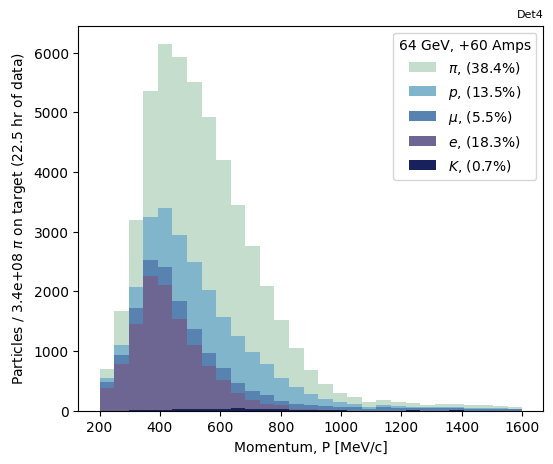

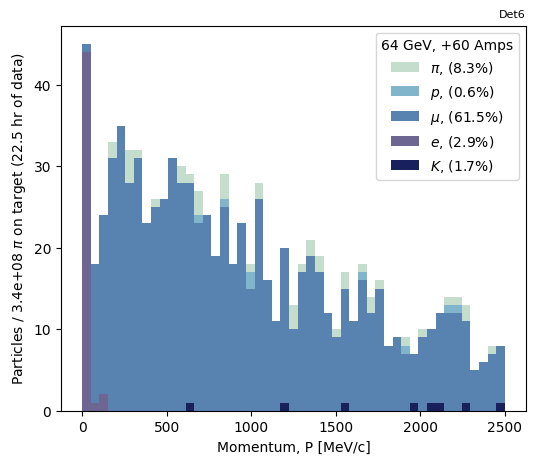

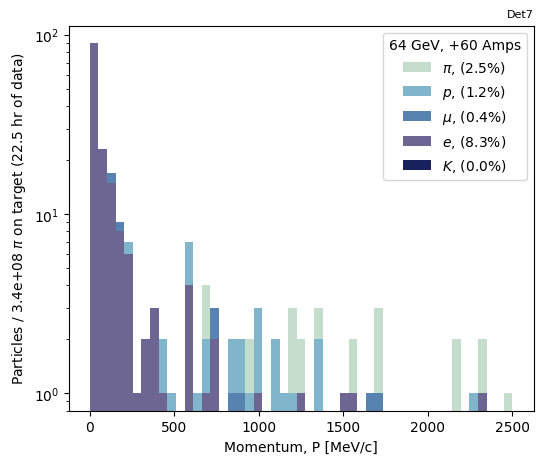

In [17]:
# for det in [4, 5]:
for det in [4, 5, 6, 7]:
    # det = 4 # LAriAT location

    if file[f'EventsDet{det}'].num_entries == 0:
        continue

    branches = [f'PxDet{det}', f'PyDet{det}', f'PzDet{det}', f'PDGidDet{det}', f'TrackPresentDet{det}']
    arrays = file[f'EventsDet{det}'].arrays(branches)#, entry_stop=2000)
    mask = arrays[f'TrackPresentDet{det}'] == True
    
    px = arrays[f'PxDet{det}'][mask]
    py = arrays[f'PyDet{det}'][mask]
    pz = arrays[f'PzDet{det}'][mask]
    p = np.sqrt(px**2 + py**2 + pz**2)
    pdg = arrays[f'PDGidDet{det}'][mask]
    
    p_kaons = p[np.abs(pdg)==321]
    p_electrons = p[np.abs(pdg)==11]
    p_muons = p[np.abs(pdg)==13]
    p_protons = p[np.abs(pdg)==2212]
    p_pions = p[np.abs(pdg)==211]
    p_others = p[ (np.abs(pdg)!=321) & (np.abs(pdg)!=11) & (np.abs(pdg)!=13) & (np.abs(pdg)!=2212) & (np.abs(pdg)!=211)]
    p_gamma = p[np.abs(pdg)==22]
    
    values = [
        # p_others,
        # p_gamma,
        p[np.abs(pdg)==321],
        p[np.abs(pdg)==11],
        p[np.abs(pdg)==13],
        p[np.abs(pdg)==2212],
        p[np.abs(pdg)==211],
    ]
    
    labels = [
        # 'others' + f', ({len(p_others) / len(p) * 100:.1f}%)',
        # 'gamma' + f', ({len(p_gamma) / len(p) * 100:.1f}%)',
        r'$K$' + f', ({len(p_kaons) / len(p) * 100:.1f}%)',
        r'$e$' + f', ({len(p_electrons) / len(p) * 100:.1f}%)',
        r'$\mu$' + f', ({len(p_muons) / len(p) * 100:.1f}%)',
        r'$p$' + f', ({len(p_protons) / len(p) * 100:.1f}%)',
        r'$\pi$' + f', ({len(p_pions) / len(p) * 100:.1f}%)'
    ]
    
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))
    
    bins = np.linspace(0, 2500, 50)
    if det == 4:
        bins = np.linspace(200, 1600, 30)
    if det == 5:
        bins = np.linspace(150, 2500, 50)
    
    ax.hist(values, bins=bins, color=colors, label=labels, stacked=True)
    
    ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='64 GeV, +60 Amps',)

    ax.set_xlabel('Momentum, P [MeV/c]')
    ax.set_ylabel(f'Particles / {n_pions:.1e} $\pi$ on target ({n_hours:.1f} hr of data)' )
    ax.set_title(f'Det{det}', loc='right', fontsize=8)
    
    if det == 7:
        ax.set_yscale('log')
    
    plt.savefig(_save_dir + f'spectra_{config}_det{det}.pdf')
    plt.show()

In [4]:
# file = uproot.open('/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/17jun2024/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_1.root')
# file = uproot.open('/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/17jun2024/merged.root')
# file = uproot.open('/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/merged_9692of35k_19jun2024.root')
file = uproot.open('/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/18jun2024/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_9070.root')


In [8]:
# files = glob('/pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/18jun2024/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_*.root')
# print('Number of files:', len(files))

files = [' /pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/21june2024/files/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_9.root']

In [9]:
for f in files:
    print('At file', f)
    file = uproot.open(f)
    name = file.keys()[0]
    arrays = file[name].arrays()
    
    with uproot.recreate('temp.root') as output_file:
    
        for det_no in [1, 2, 3, 4, 5, 6, 7]:
    
            mask = arrays[f'TrackPresentDet{det_no}'] == True
            output_file[f'EventsDet{det_no}'] = arrays[mask]

    out_file_name = f[:-5] + '_reprocessed.root'
    os.system(f'mv temp.root {out_file_name}')


At file  /pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/21june2024/files/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_9.root


In [12]:
with uproot.recreate("test.root") as output_file:
    output_file["EventsDet4"] = arrays

In [17]:
file = uproot.open('test.root')
file.keys()

['EventsDet1;1',
 'EventsDet2;1',
 'EventsDet3;1',
 'EventsDet4;1',
 'EventsDet5;1',
 'EventsDet6;1',
 'EventsDet7;1']

In [3]:
histos = []
bins = np.linspace(0, 3000, 50)

for i, file in enumerate(files):
    file = uproot.open(file)
    name = file.keys()[0][:-2]
    print(i, name)
    arrays = file[name].arrays()

    mask = arrays['TrackPresentDet4'] == True

    px = arrays['PxDet4'][mask]
    py = arrays['PyDet4'][mask]
    pz = arrays['PzDet4'][mask]
    p = np.sqrt(px**2 + py**2 + pz**2)
    pdg = arrays['PDGidDet4'][mask]

    h, _ = np.histogram(p, bins)
    histos.append(ak.to_numpy(h))

    if i > 10: break

0 EventTree_Spill241
1 EventTree_Spill371
2 EventTree_Spill36
3 EventTree_Spill170
4 EventTree_Spill603
5 EventTree_Spill364
6 EventTree_Spill65
7 EventTree_Spill229
8 EventTree_Spill57
9 EventTree_Spill469
10 EventTree_Spill31
11 EventTree_Spill61


In [4]:
histo_merged = histos[0]
for i in range(1, len(histos)):
    histo_merged = np.add(histo_merged, histos[i])

histo_merged

array([45.,  0.,  1.,  6.,  7.,  8.,  6.,  8.,  7.,  5.,  7.,  2.,  2.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

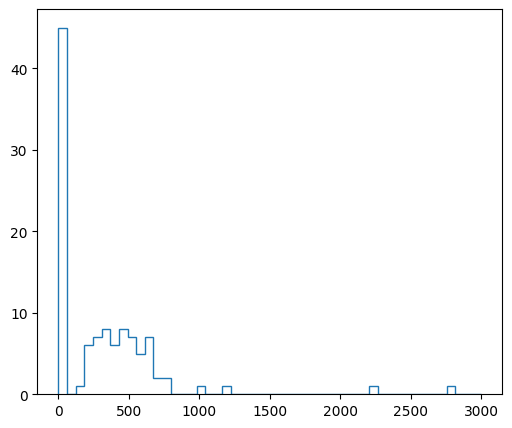

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

ax.stairs(histo_merged, bins, label='Simple histogram')

In [68]:
trees = file.keys()
trees

['EventTree_Spill1059;1']

In [61]:
# file['EventTree_Spill1'].keys()

In [65]:
for tree in trees:

    tree_name = tree[:-2]
    print(tree_name)
    break

EventTree_Spill117


In [5]:
arrays = file['EventTree_Spill1'].arrays()

KeyInFileError: not found: 'EventTree_Spill1' (with any cycle number)

    Available keys: 'EventTree_Spill1059;1'

in file /pnfs/lariat/persistent/users/mdeltutt/BeamLineSimOutputs/pos60Amps/18jun2024/MergedAtStartLinesim_LAriaT_13degProdxn_10degAna_SurveyedGeom_10000jobsof35k_64GeV_pos60Amps_9070.root

In [54]:
len(arrays)

439148

In [47]:
np.sum(arrays['TrackPresentDet4'])

np.int64(12)

In [48]:
mask = arrays['TrackPresentDet4'] == True

px = arrays['PxDet4'][mask]
py = arrays['PyDet4'][mask]
pz = arrays['PzDet4'][mask]
p = np.sqrt(px**2 + py**2 + pz**2)
pdg = arrays['PDGidDet4'][mask]

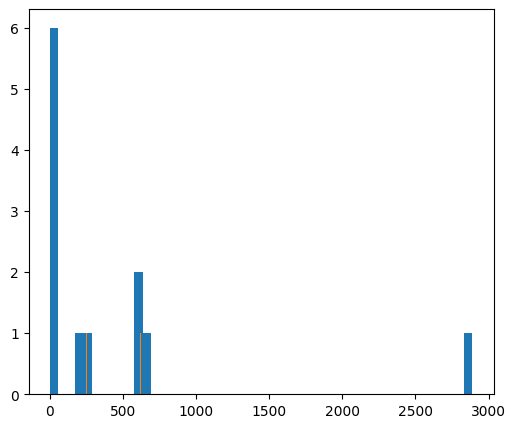

In [49]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 5))

ax.hist(p, bins=50)
ax.hist(p[pdg==211], bins=50)

plt.show()